# Usage (details: phases)
Here, how to set phases in scenario analysis will be explained. As an example, use the records in India.

## Preperation

In [1]:
# Standard users
# !pip install covsirphy
# Developers (Note: this notebook is in example directory)
import os
os.chdir("../")

In [2]:
import covsirphy as cs
cs.__version__

'2.6.0-theta.new.72.167.fix.120.155.157.163.164.165.174.188'

In [3]:
# Load datasets
data_loader = cs.DataLoader("input")
jhu_data = data_loader.jhu(verbose=False)
population_data = data_loader.population(verbose=False)
print(jhu_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Working paper, doi: 10.13140/RG.2.2.11649.81763.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation

In [4]:
# Create instance of `Scenario` class
scenario = cs.Scenario(jhu_data, population_data, country="India", province=None)

In [5]:
# Summarize main scenario
scenario.summary()

""


Note:  
This is empty because no phases are registered. Term "phase" means a sequential dates in which the parameters of SIR-derived models are fixed. The details will be explained later.

Just for demonstration, we will fix the first/end date of the records here. This is un-necessary for your analysis.

In [6]:
# Fix the first date of records
scenario.first_date = "01Mar2020"
# Fix the last date of records
scenario.last_date = "16Jul2020"
# Summarize (Empty because no phases are registered)
scenario.summary()

""


## Set phases with S-R trend analysis
How can we set phases?

Here, we will use "S-R trend analysis" explained in [S-R trend analysis section in "Kaggle: COVID-19 data with SIR model"](https://www.kaggle.com/lisphilar/covid-19-data-with-sir-model#S-R-trend-analysis). $S$ (Susceptible) and $R$ (Recovered) show the following relationship in SIR-derived models. $S_{(R)}$ means $S$ as a function of $R$.

$$S_{(R)} = N e^{-a R}$$

where $N$ is total population and $a=\cfrac{\beta}{N \gamma}$ is a constant.  
This leads to
$$\log S_{(R)} = - a R + \log N$$

$\log S$ decreases constantly with increase of $R$, when the records follow a SIR-derived model and the parameter values of the model are constant. With logarithmic y-axis scale, plot of $(x, y) = (R, S)$ shows a line. 

The slope of the line may change when the parameter values ($\beta$ and $\gamma$) are changed. To detect the dates when the parameter values were changed, we will find the change points of $\log S$ as a function of $R$, using [ruptures: change point detection in Python](https://github.com/deepcharles/ruptures). We call the period from a change point to the next change point as a "phase" in this analysis.

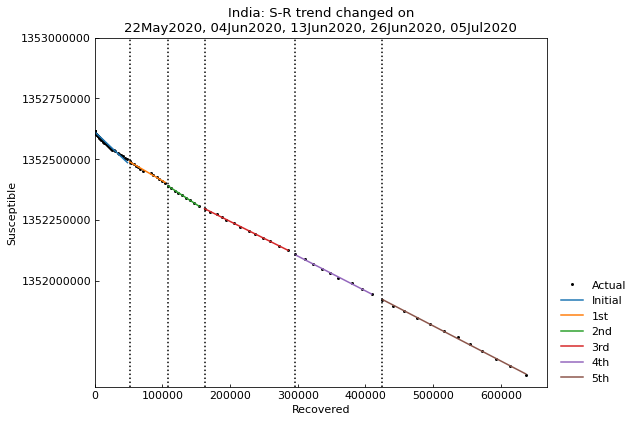

In [7]:
# Set phase with S-R trend analysis and delete initial (0th) phase
scenario.trend(set_phases=True)
# This is the same as
# scenario.trend(set_phases=True, include_init_phase=True)
# scenario.delete(phases=["0th"])

We found five change points from 01May2020 to 20Jul2020. This means that there 6 phases (Initial, 1st, 2nd,...5th). Here, we removed Initial (0th) phase because the number of cases is small in 0th phase and may not show SIR-like trend.

In [8]:
scenario.summary()

,Type,Start,End,Population
1st,Past,22May2020,03Jun2020,1352617328
2nd,Past,04Jun2020,12Jun2020,1352617328
3rd,Past,13Jun2020,25Jun2020,1352617328
4th,Past,26Jun2020,04Jul2020,1352617328
5th,Past,05Jul2020,16Jul2020,1352617328


## (Optional) Remove un-necessary change points manually
The slope of 4th phase seems to equal to that of 3rd phase. Here, we will combine 3rd phase and 4th phase here and reset phase names.

In [9]:
# Before: 3rd is 16Jun2020-23Jun2020, 4th is 24Jun2020-04Jul2020
# After: 3rd is 16Jun2020-04Jul2020, 4th is the same as old 5th
scenario.combine(phases=["3rd", "4th"])
scenario.summary()

,Type,Start,End,Population
1st,Past,22May2020,03Jun2020,1352617328
2nd,Past,04Jun2020,12Jun2020,1352617328
3rd,Past,13Jun2020,04Jul2020,1352617328
4th,Past,05Jul2020,16Jul2020,1352617328


Show the trend with manually set change points.

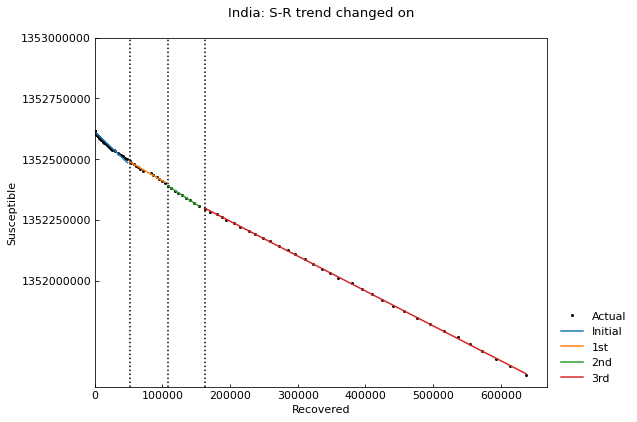

In [10]:
scenario.trend(set_phases=False)

## (Optional) Separate phases manually
Because point of $(x, y) = (S, R)$ jumped on 30May2020, we will separete the 1st phase with this change point and reset phase names.

In [11]:
# Before: 1st is 20May2020-05Jun2020
# After: 1st is 20May2020-29May2020, 2nd is 30May2020-05Jun2020
scenario.separate(date="30May2020", phase="1st")
scenario.summary()

,Type,Start,End,Population
1st,Past,22May2020,29May2020,1352617328
2nd,Past,30May2020,03Jun2020,1352617328
3rd,Past,04Jun2020,12Jun2020,1352617328
4th,Past,13Jun2020,04Jul2020,1352617328
5th,Past,05Jul2020,16Jul2020,1352617328


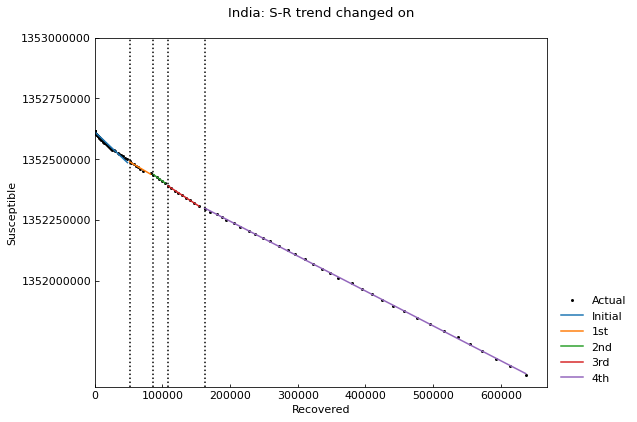

In [12]:
scenario.trend(set_phases=False)

## (Optional) Delete phases manually
Because 1st phase seems un-stable, delete the 1st phase and reset the phase names.

In [13]:
# Remove 1st phase
scenario.delete(phases=["1st"])
scenario.summary()

,Type,Start,End,Population
0th,Past,01Mar2020,29May2020,1352617328
1st,Past,30May2020,03Jun2020,1352617328
2nd,Past,04Jun2020,12Jun2020,1352617328
3rd,Past,13Jun2020,04Jul2020,1352617328
4th,Past,05Jul2020,16Jul2020,1352617328


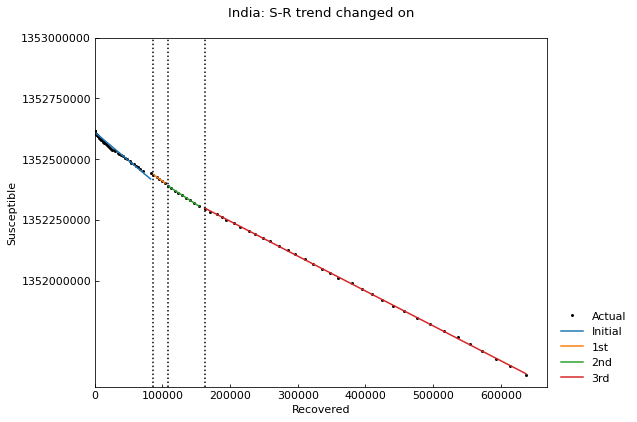

In [14]:
scenario.trend(set_phases=False)

## (Optional) Add phases one by one
In the previous sections, we started with S-R trend analysis. We can create phases without this analysis when you have a new idea to find change points.

In [15]:
# Clear all phases
scenario.clear(include_past=True).summary()

""


In [16]:
# Set 0th phase to set the start date of 1st phase
scenario.add(end_date="29May2020")
# Add 1st phase and delete 0th phase
scenario.add(end_date="05Jun2020").delete(phases=["0th"])
# Add 2nd phase
scenario.add(end_date="15Jun2020")
# Add 3rd phase
scenario.add(end_date="04Jul2020")
# Add 4th phase to the last of the records
scenario.add().summary()

,Type,Start,End,Population
1st,Past,30May2020,05Jun2020,1352617328
2nd,Past,06Jun2020,15Jun2020,1352617328
3rd,Past,16Jun2020,04Jul2020,1352617328
4th,Past,05Jul2020,16Jul2020,1352617328


## Parameter estimation of ODE models
Here, we will use SIR-F model.

In [17]:
scenario.estimate(cs.SIRF)


<SIR-F model: parameter estimation>

Running optimization with 4 CPUs...

	4th phase (05Jul2020 - 16Jul2020): finished  669 trials in 0 min 20 sec

	1st phase (30May2020 - 05Jun2020): finished  226 trials in 0 min  5 sec

	3rd phase (16Jun2020 - 04Jul2020): finished 1116 trials in 0 min 30 sec

	2nd phase (06Jun2020 - 15Jun2020): finished 1937 trials in 1 min  0 sec

Completed optimization. Total: 1 min 20 sec

## Main scenario
To investigate the effect of parameter changes, we will perform scenario analysis. In the main scenario, we will assume that the parameter values do not change after the last past phase.

In [18]:
# Add 5th phase with the parameter values of 4th phase (until 01Aug2020)
scenario.add(end_date="01Aug2020", name="Main")
# Add 6th phase with the parameter values of 4th phase (100 days)
scenario.add(days=100, name="Main")
# Show the parameter values of SIR-F model and reproduction number
scenario.summary(columns=["Start", "End", *cs.SIRF.PARAMETERS, "Rt"])

,Start,End,theta,kappa,rho,sigma,Rt
0th,30May2020,05Jun2020,0.021563,0.000071,0.014422,0.006719,2.08
1st,06Jun2020,15Jun2020,0.000693,0.000384,0.012793,0.007276,1.67
2nd,16Jun2020,04Jul2020,0.016662,0.000092,0.014905,0.010464,1.39
3rd,05Jul2020,16Jul2020,0.017537,0.000039,0.015745,0.010957,1.41
4th,17Jul2020,01Aug2020,0.017537,0.000039,0.015745,0.010957,1.41
5th,02Aug2020,10Nov2020,0.017537,0.000039,0.015745,0.010957,1.41


## Medicine scenario
To investigate the effect of new medicines, we will assume that $\sigma$ will be double in the future phases in Medicine scenario.

In [19]:
# Initialize Medicine scenario
scenario.clear(name="Medicine")
# Calculate double value of sigma (baseline: 4th phase)
sigma_opt = scenario.get("sigma", phase="4th", name="Main") * 2
# Add 5th phase (until 01Aug2020, sigma: double)
scenario.add(end_date="01Aug2020", name="Medicine", sigma=sigma_opt)
# Add 6th phase (100 days, sigma: double)
scenario.add(days=100, name="Medicine", sigma=sigma_opt)
# Show the parameter values of SIR-F model and reproduction number
scenario.summary(columns=["Start", "End", *cs.SIRF.PARAMETERS, "Rt"])

Start        End     theta     kappa       rho     sigma  \
Scenario Phase                                                                 
Main     0th    30May2020  05Jun2020  0.021563  0.000071  0.014422  0.006719   
         1st    06Jun2020  15Jun2020  0.000693  0.000384  0.012793  0.007276   
         2nd    16Jun2020  04Jul2020  0.016662  0.000092  0.014905  0.010464   
         3rd    05Jul2020  16Jul2020  0.017537  0.000039  0.015745  0.010957   
         4th    17Jul2020  01Aug2020  0.017537  0.000039  0.015745  0.010957   
         5th    02Aug2020  10Nov2020  0.017537  0.000039  0.015745  0.010957   
Medicine 0th    30May2020  05Jun2020  0.021563  0.000071  0.014422  0.006719   
         1st    06Jun2020  15Jun2020  0.000693  0.000384  0.012793  0.007276   
         2nd    16Jun2020  04Jul2020  0.016662  0.000092  0.014905  0.010464   
         3rd    05Jul2020  16Jul2020  0.017537  0.000039  0.015745  0.010957   
         4th    17Jul2020  01Aug2020  0.017537  0.000039  0.015745  0.021914   
         5th    02Aug2020  10Nov2020  0.017537  0.000039  0.015745  0.021914   

                  Rt  
Scenario Phase        
Main     0th    2.08  
         1st    1.67  
         2nd    1.39  
         3rd    1.41  
         4th    1.41  
         5th    1.41  
Medicine 0th    2.08  
         1st    1.67  
         2nd    1.39  
         3rd    1.41  
         4th    0.70  
         5th    0.70

## Compare the scenarios
Currently. we can compare the scenarios with the following indexes.
- max(Infected): max value of Infected
- argmax(Infected): the date when Infected shows max value
- Infected on ...: Infected on the end date of the last phase
- Fatal on ...: Fatal on the end date of the last phase

In [20]:
scenario.describe()

,max(Infected),argmax(Infected),Infected on 11Nov2020,Fatal on 11Nov2020
Main,7863105,11Nov2020,7863105,569597
Medicine,364943,17Jul2020,3808,43010
